# Line detection with Canny Filter and Hough Transform
    
In this tutorial, we use essentially Canny Filter and Hough Transform to detect lines. Why Hough Transform ? With only colour selection, we can not find parameters of detected lines and it's also limited by lines' colour. So, Hough Transformation is here to help us mathematically identify lines on a frame.

Our processing consist of :
- [x] Gaussian filter to favorize Canny edge detection
- [x] Canny edge detection to detect edges, so all of the potential line-candidates
- [x] Zone of interest filtering, to eliminate non-desired detections
- [x] Probabilistic Hough Transform to detect end-points of each detected lines

As you see, we need to find parameters for Gaussian Filter, Canny Edge detection, Hough Transform,... It could work well on a specific image frame but perhaps not on the others, so the tricky part is how to always use good parameters. We will work on this difficult puzzle later. In this tutorial, we just need to understand the basics usages of Canny Filter and Hough Transform.
Furthermore, to detect lane's lines in a curve, more sophisticated technics are needed, they will be mentioned in other tutorials.

*My previous tutorial on line-detection by colour selection and zone of interest filtering :*
https://github.com/nguyenrobot/line_detection_by_color_zone_interest

In [1]:
#Create main functions
#Created on Fri Aug 14 22:13:16 2020
""""
@author: nguyenrobot
# copyright nguyenrobot
# https://github.com/nguyenrobot/

"""

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import cv2
import math
#%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def color_selection(frame, RGB_thd):
# Define color selection threshold
# Example : to keep white and yellow RGB_thd should be
# RGB_thd = [[200, 200, 200], [200, 200, 0]]

    color_selection_ind = np.zeros((frame.shape[0], frame.shape[1]), dtype=bool)
    result              = np.copy(frame)
    
    # Define selection by color / below the threshold
    for RGB_thd_i in RGB_thd:
        color_selection_ind[:,:] = ((result[:,:,0] > RGB_thd_i[0]) & \
                                    (result[:,:,1] > RGB_thd_i[1]) & \
                                    (result[:,:,2] > RGB_thd_i[2])) \
                                    | color_selection_ind[:,:]
    result[~color_selection_ind] = [0, 0, 0]
    #result                     = np.copy(result[color_selection_ind])
    return result, color_selection_ind

# We will work on a road image coming from Udacity <solidYellowLeft.jpg>.
This image is very interesting because it introduces some challenges for our algorithm :
*    A road-edge on the far left side
*    A yellow line on the left
*    A white dashed-line on the right
*    A two more white dashed-lines on the far right side

If our algorithm is robust, it should detect :
*    Left solid-line and right dashed-line of ego-vehicle's lane
*    Road-edge line for the left next-lane
*    Dashed-line for the right next-lane

## Let's see how far can we go...

Image Credit : Udacity


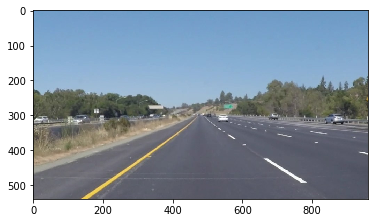

In [2]:
frame = img.imread('test_images/solidYellowLeft.jpg')
plt.imshow(frame)
print("Image Credit : Udacity")

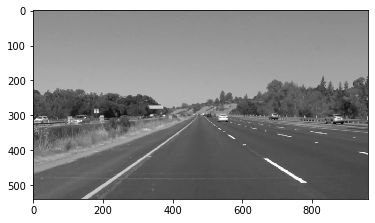

In [3]:
# We convert original image into gray-scale to be able to work with Gaussian Filter and Canny Edge detection
frame_gray = frame

frame_gray = grayscale(frame_gray)
plt.figure()
plt.imshow(frame_gray, cmap='gray')
plt.imsave('result_images/frame_gray.png', frame_gray, cmap='gray')

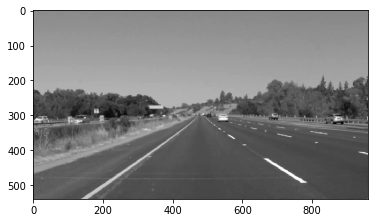

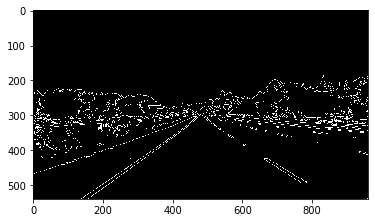

In [7]:
kernel_size     = 5
frame_gaussian  = gaussian_blur(frame_gray, kernel_size)
plt.figure()
plt.imshow(frame_gaussian, cmap='gray')
plt.imsave('result_images/frame_gaussian.png', frame_gaussian, cmap='gray')

low_threshold   = 5
high_threshold  = 100
frame_canny     = canny(frame_gaussian, low_threshold, high_threshold)
plt.figure()
plt.imshow(frame_canny, cmap='gray')
plt.imsave('result_images/frame_canny.png', frame_canny, cmap='gray')

Then we apply a zone of interest selection to eliminate non-desired detection

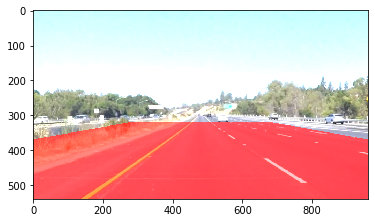

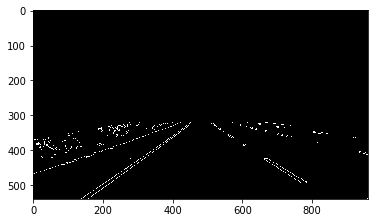

In [9]:
vertices        = np.array([[(0,np.int(frame.shape[0]/2) + 100), \
                      (0,frame.shape[0]-1), \
                      (frame.shape[1]-1,frame.shape[0]-1), \
                      (frame.shape[1]-1,np.int(frame.shape[0]/2) + 100), \
                      (np.int(frame.shape[1]/2) + 200, np.int(frame.shape[0]/2) + 50), \
                      (np.int(frame.shape[1]/2) - 200, np.int(frame.shape[0]/2) + 50)]], \
                    dtype=np.int32)
zone_interest   = np.copy(frame)
cv2.fillPoly(zone_interest, vertices, [255, 0, 0])
zone_interest   = weighted_img(zone_interest, frame)
plt.figure()
plt.imshow(zone_interest, cmap='gray')
plt.imsave('result_images/zone_interest.png', zone_interest)

frame_interest  = region_of_interest(frame_canny, vertices)
plt.figure()
plt.imshow(frame_interest, cmap='gray')
plt.imsave('result_images/frame_interest.png', frame_interest, cmap='gray')

Finally, we use Probabilistic Hough Transform to detect end-points of each detected line-segment.

To understand more about Hough Transform, openCV documentation is quite good for beginers :
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

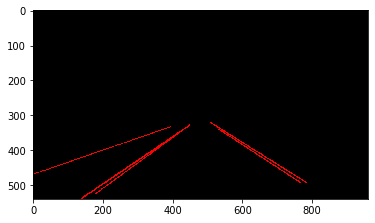

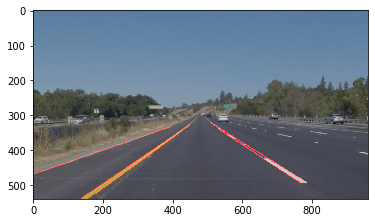

In [10]:
minLineLength   = 100
maxLineGap      = 100
rho             = 1
theta           = np.pi/180
minimum_vote    = 100
frame_hough, lines   = hough_lines(frame_interest, rho, theta, minimum_vote, minLineLength, maxLineGap)
plt.figure()
plt.imshow(frame_hough, cmap='gray')
plt.imsave('result_images/frame_hough.png', frame_hough, cmap='gray')

frame_weighted  = weighted_img(frame_hough, frame)
plt.figure()
plt.imshow(frame_weighted, cmap='gray')
plt.imsave('result_images/frame_weighted.png', frame_weighted)

It's quite good in the end, we can detect :  
- [x] Road-edge line of right next-lane
- [x] Left yellow solid-line of ego-vehicle's lane
- [x] Right white dashed-line of ego-vehicle's lane

However, we can not detect two dashed-line on the far right side because their line-segments are so tiny.  
What if we try to reduce minLineLength and minimum_vote of Hough Transform ?

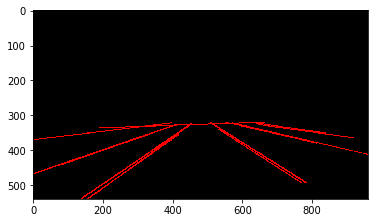

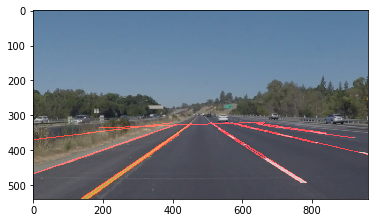

In [11]:
minLineLength   = 50
maxLineGap      = 200
rho             = 1
theta           = np.pi/180
minimum_vote    = 50
frame_hough_new, lines   = hough_lines(frame_interest, rho, theta, minimum_vote, minLineLength, maxLineGap)
plt.figure()
plt.imshow(frame_hough_new, cmap='gray')
plt.imsave('result_images/frame_hough_new.png', frame_hough_new, cmap='gray')

frame_weighted_new  = weighted_img(frame_hough_new, frame)
plt.figure()
plt.imshow(frame_weighted_new, cmap='gray')
plt.imsave('result_images/frame_weighted_new.png', frame_weighted_new, cmap='gray')

Uhm,.. we detect them but other noises come out. So, we can try to adjust our Gaussian Filter and Canny Edge detection to have better results. But in the end, it's so tricky to make our processing always works well on other frames...

Lest's take a try with color selection, this time we will keep Yellow and White pixels.  
So we would have :  
- [x]     Colour Selection  
- [x]     Gaussian filter  
- [x]     Canny edge detection 
- [x]     Zone of interest filtering  
- [x]     Probabilistic Hough Transform  

Image Credit : Udacity


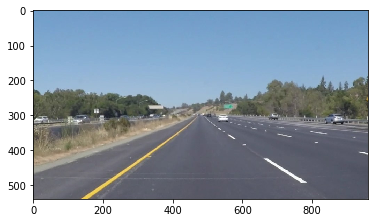

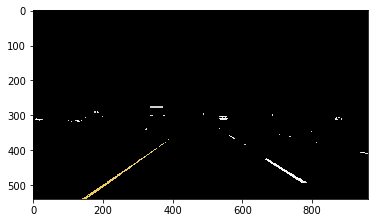

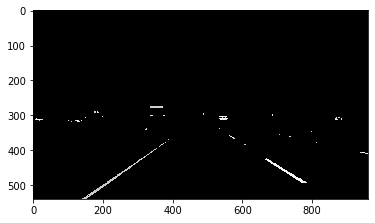

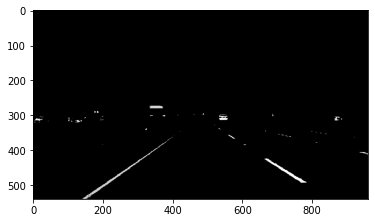

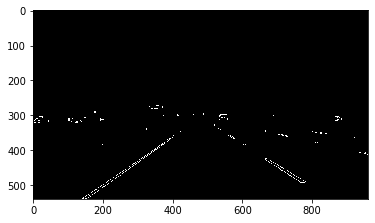

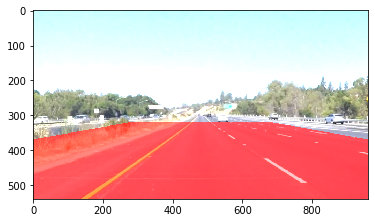

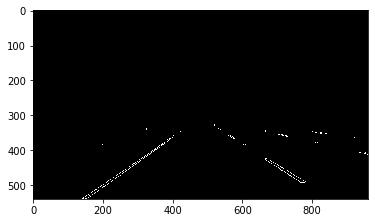

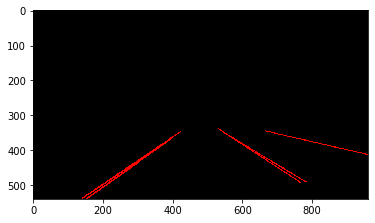

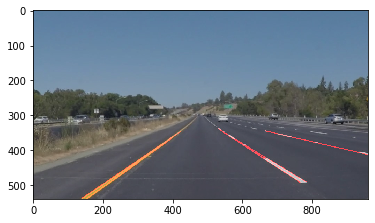

In [13]:
frame = img.imread('test_images/solidYellowLeft.jpg')
plt.imshow(frame)
print("Image Credit : Udacity")

frame_color_selection = np.copy(frame)
RGB_thd               = [[200, 200, 200], [200, 200, 0]]
frame_color_selection, color_selection_ind = color_selection(frame_color_selection, RGB_thd)
plt.figure()
plt.imshow(frame_color_selection)
plt.imsave('result_images/frame_color_selection.png', frame_color_selection)

frame_gray = grayscale(frame_color_selection)
plt.figure()
plt.imshow(frame_gray, cmap='gray')
plt.imsave('result_images/frame_gray_2.png', frame_gray, cmap='gray')

kernel_size     = 5
frame_gaussian  = gaussian_blur(frame_gray, kernel_size)
plt.figure()
plt.imshow(frame_gaussian, cmap='gray')
plt.imsave('result_images/frame_gaussian_2.png', frame_gaussian, cmap='gray')

low_threshold   = 5
high_threshold  = 100
frame_canny     = canny(frame_gaussian, low_threshold, high_threshold)
plt.figure()
plt.imshow(frame_canny, cmap='gray')
plt.imsave('result_images/frame_canny_2.png', frame_canny, cmap='gray')

vertices        = np.array([[(0,np.int(frame.shape[0]/2) + 100), \
                      (0,frame.shape[0]-1), \
                      (frame.shape[1]-1,frame.shape[0]-1), \
                      (frame.shape[1]-1,np.int(frame.shape[0]/2) + 100), \
                      (np.int(frame.shape[1]/2) + 200, np.int(frame.shape[0]/2) + 50), \
                      (np.int(frame.shape[1]/2) - 200, np.int(frame.shape[0]/2) + 50)]], \
                    dtype=np.int32)
zone_interest   = np.copy(frame)
cv2.fillPoly(zone_interest, vertices, [255, 0, 0])
zone_interest   = weighted_img(zone_interest, frame)
plt.figure()
plt.imshow(zone_interest, cmap='gray')

frame_interest  = region_of_interest(frame_canny, vertices)
plt.figure()
plt.imshow(frame_interest, cmap='gray')
plt.imsave('result_images/frame_interest_2.png', frame_interest, cmap='gray')

minLineLength   = 50
maxLineGap      = 200
rho             = 1
theta           = np.pi/180
minimum_vote    = 50
frame_hough_new, lines   = hough_lines(frame_interest, rho, theta, minimum_vote, minLineLength, maxLineGap)
plt.figure()
plt.imshow(frame_hough_new, cmap='gray')
plt.imsave('result_images/frame_hough_new_2.png', frame_hough_new, cmap='gray')

frame_weighted_new  = weighted_img(frame_hough_new, frame)
plt.figure()
plt.imshow(frame_weighted_new, cmap='gray')
plt.imsave('result_images/frame_weighted_new_2.png', frame_weighted_new, cmap='gray')

It's pretty good, we can eliminate noise detections but also our detected road-edge.. We can make a fusion of this result with the previous result to have a full detection of road-edge line, solid-line and dashed-line.